In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from util import open_slideshow

import librosa 
import matplotlib.pyplot as plt
from tqdm import tqdm
from config import *
import h5py
from util import DEFAULT_TOKENS
import librosa

2024-09-27 16:07:38.281092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 16:07:38.281131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 16:07:38.282220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 16:07:38.289230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 16:07:39.084085: W tensorflow/comp

In [ ]:
samples_f = h5py.File(INTERMEDIATE / '22sr_samples.hdf5', 'r')

In [63]:
def logmel(recording, n_mels, fmax=8000): # TODO check fast trill
    s = np.array(samples_f[recording]['X'])
    mel_spectrogram = librosa.feature.melspectrogram(y=s, sr=22_000, n_mels=n_mels, fmax=fmax)
    return librosa.power_to_db(mel_spectrogram, ref=np.max)

# look at something
rec = list(samples_f)[0]
S = logmel(rec, 128)
S

array([[-28.05003 , -29.645664, -32.086998, ..., -31.36621 , -30.233818,
        -29.987171],
       [-31.378098, -29.82434 , -27.91961 , ..., -23.402916, -31.45676 ,
        -34.393967],
       [-33.445087, -29.342468, -24.091003, ..., -23.321014, -26.536247,
        -29.755867],
       ...,
       [-33.050774, -32.982365, -34.983177, ..., -39.47357 , -38.69662 ,
        -40.5065  ],
       [-37.806686, -36.302864, -34.611736, ..., -38.374294, -38.114086,
        -41.645348],
       [-35.40969 , -32.85029 , -33.64274 , ..., -38.562336, -40.69248 ,
        -43.422947]], dtype=float32)

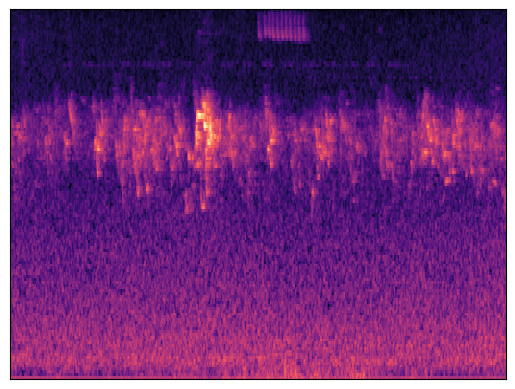

In [62]:

# look at some annotations

w = 6
w = librosa.time_to_frames(w)

annotations = pd.read_csv(ANNOTATIONS / 'manual_annotations' / 'initial_manual_annotations.csv')
annotated_recordings = annotations.recording.unique()

np.random.seed(0)
np.random.shuffle(annotated_recordings)

def view(n_mels, fmax):
    for rec in annotated_recordings[:1]:
        Y = np.array(samples_f[rec]['Y'])
        cols, rows = np.where(Y)
        start = rows[10]
        
        S = logmel(rec, 128, fmax=fmax)
        s = librosa.samples_to_frames(start)
        librosa.display.specshow(S[:, max(s-w, 0):s+w])
        plt.show()

view(40, 8000)

In [69]:
# create the ds
logmel_f.close()
logmel_f = h5py.File(INTERMEDIATE / 'logmel.hdf5', 'w')

for rec in tqdm(list(samples_f)):
    g = logmel_f.create_group(rec)
    lm = logmel(rec, n_mels=40, fmax=8000)
    g.create_dataset("40mels", data=lm, dtype=np.float32)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [04:16<00:00,  1.38it/s]


In [72]:
r = list(logmel_f)[0]
np.array(logmel_f[r]['40mels'])

array([[-26.253273, -21.243193, -18.951637, ..., -19.427448, -19.768314,
        -23.362041],
       [-23.122465, -17.543875, -13.474384, ..., -20.674198, -19.589031,
        -21.42303 ],
       [-16.162746, -12.190653,  -9.78956 , ..., -22.048723, -20.581833,
        -19.665518],
       ...,
       [-31.950903, -29.454414, -28.715744, ..., -32.04233 , -31.80808 ,
        -31.305449],
       [-33.344833, -30.245258, -29.228294, ..., -36.142883, -35.6294  ,
        -36.269653],
       [-32.07546 , -30.884903, -30.950974, ..., -36.77188 , -36.717056,
        -38.35524 ]], dtype=float32)

In [74]:
logmel_f.close()
samples_f.close()